In [1]:
%pylab inline
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import re
import datetime as dt
import matplotlib.pyplot as plt
import time
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
def ht(df, n = 5):
    print(df.shape)
    if len(df) <= 2*n:
        display(df)
    else:
        display(df.head(n).append(df.tail(n)))
def pf(df):
    pd.set_option('display.max_rows', len(df))
    display(df)
    pd.reset_option('display.max_rows')

In [3]:
pd.set_option('display.max_columns', 100)
plt.rc('figure', figsize=(13, 7))
plt.style.use('ggplot')

In [10]:
from sklearn import datasets

In [6]:
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [145]:
breast_cancer = datasets.load_breast_cancer()

In [146]:
print(breast_cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

In [160]:
breast_cancer.data.shape

(569, 30)

In [173]:
training_x = breast_cancer.data
training_x = StandardScaler().fit_transform(training_x)
training_y = breast_cancer.target

In [11]:
digits = datasets.load_digits()

In [159]:
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each bloc

In [15]:
digits.data.shape

(1797, 64)

<Figure size 936x504 with 0 Axes>

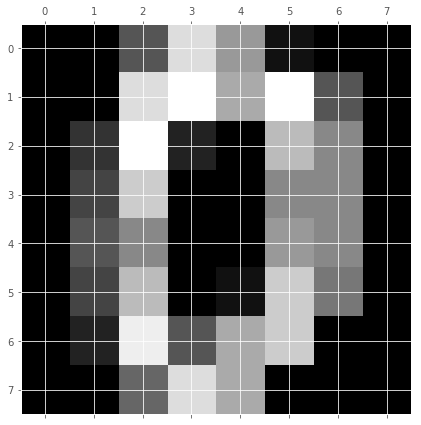

In [21]:
plt.gray()
plt.matshow(digits.images[0]) 
plt.show()

In [182]:
training_x = digits.data
training_x = StandardScaler().fit_transform(training_x)
training_y = digits.target

### Clustering

In [61]:
from sklearn.cluster import KMeans as kmeans
from sklearn.mixture import GaussianMixture as GMM
from collections import defaultdict

from collections import Counter

from sklearn.metrics import adjusted_mutual_info_score as ami, silhouette_score as sil_score, silhouette_samples as sil_samples

In [89]:
from sklearn.manifold import TSNE

In [62]:
from sklearn.metrics import accuracy_score
def cluster_acc(y, cluster_labels):
    assert (y.shape == cluster_labels.shape)
    pred = np.empty_like(y)
    for label in set(cluster_labels):
        mask = cluster_labels == label
        sub = y[mask]
        target = Counter(sub).most_common(1)[0][0]
        pred[mask] = target
    return accuracy_score(y, pred)

In [173]:
training_x = breast_cancer.data
training_x = StandardScaler().fit_transform(training_x)
training_y = breast_cancer.target

In [328]:
training_x = digits.data
training_x = StandardScaler().fit_transform(training_x)
training_y = digits.target

In [339]:
seed = 7

In [330]:
sse = defaultdict(list)
ll = defaultdict(list)
bic = defaultdict(list)
sil = defaultdict(lambda: defaultdict(list))
sil_s = np.empty(shape=(2*len(_clusters)*training_x.shape[0],4), dtype='<U21')
acc = defaultdict(lambda: defaultdict(float))
adj_mi = defaultdict(lambda: defaultdict(float))
km = kmeans(random_state=seed)
gmm = GMM(random_state=seed)

j = 0
for k in range(2, 16):
    km.set_params(n_clusters=k)
    gmm.set_params(n_components=k)
    km.fit(training_x)
    gmm.fit(training_x)

    km_labels = km.predict(training_x)
    gmm_labels = gmm.predict(training_x)

    sil[k]['Kmeans'] = sil_score(training_x, km_labels)
    sil[k]['GMM'] = sil_score(training_x, gmm_labels)

    km_sil_samples = sil_samples(training_x, km_labels)
    gmm_sil_samples = sil_samples(training_x, gmm_labels)

    for i, x in enumerate(km_sil_samples):
        sil_s[j] = [k, 'Kmeans', round(x, 6), km_labels[i]]
        j += 1
    for i, x in enumerate(gmm_sil_samples):
        sil_s[j] = [k, 'GMM', round(x, 6), gmm_labels[i]]
        j += 1

    sse[k] = [km.score(training_x)]
    ll[k] = [gmm.score(training_x)]
    bic[k] = [gmm.bic(training_x)]

    acc[k]['Kmeans'] = cluster_acc(training_y, km_labels)
    acc[k]['GMM'] = cluster_acc(training_y, gmm_labels)

    adj_mi[k]['Kmeans'] = ami(training_y, km_labels)
    adj_mi[k]['GMM'] = ami(training_y, gmm_labels)

sse = (-pd.DataFrame(sse)).T
sse.index.name = 'k'
sse.columns = ['{} sse (left)'.format('MNIST')]

ll = pd.DataFrame(ll).T
ll.index.name = 'k'
ll.columns = ['{} log-likelihood'.format('MNIST')]

bic = pd.DataFrame(bic).T
bic.index.name = 'k'
bic.columns = ['{} BIC'.format('MNIST')]

sil = pd.DataFrame(sil).T
sil_s = pd.DataFrame(sil_s, columns=['k', 'type', 'score', 'label']).set_index('k')  #.T
acc = pd.DataFrame(acc).T
adj_mi = pd.DataFrame(adj_mi).T

sil.index.name = 'k'
sil_s.index.name = 'k'
acc.index.name = 'k'
adj_mi.index.name = 'k'

/Users/frankz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/frankz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/frankz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/frankz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior 

In [90]:
training_x2D = TSNE(verbose=10, random_state=seed).fit_transform(training_x)
ds_2d = pd.DataFrame(np.hstack((training_x2D, np.atleast_2d(training_y).T)),columns=['x', 'y', 'target'])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1797 samples in 0.004s...
[t-SNE] Computed neighbors for 1797 samples in 0.369s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 8.121136
[t-SNE] Computed conditional probabilities in 0.070s
[t-SNE] Iteration 50: error = 72.6970596, gradient norm = 0.1310373 (50 iterations in 0.971s)
[t-SNE] Iteration 100: error = 64.2919693, gradient norm = 0.0582100 (50 iterations in 0.491s)
[t-SNE] Iteration 150: error = 62.9450455, gradient norm = 0.0331543 (50 iterations in 0.560s)
[t-SNE] Iteration 200: error = 62.3984528, gradient norm = 0.0286782 (50 iterations in 0.576s)
[t-SNE] Iteration 250: error = 62.0874176, gradient norm = 0.0246404 (50 iterations in 0.610s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.087418
[t-SNE] Iteration 300: error = 1.0584732, gradient norm = 0.0009725 (50 iterations in 0.471s)

In [331]:
def plot_tsne(title, df):
    plt.close()
    plt.figure()
    plt.title(title)
    plt.grid()
    plt.tight_layout()

    possible_clusters = list(set(df['target']))

    ax = plt.gca()
    ax.set_title(title)
    ax.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=10)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.grid(None)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('tight')

    return plt

def plot_sse(title, df, xlabel='Number of Clusters', ylabel='SSE'):
    plt.close()
    plt.figure()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.tight_layout()

    plt.plot(df.index.values, df.iloc[:, 0], 'o-', linewidth=1, markersize=2)
    plt.legend(loc="best")

    return plt

def plot_kmeans(title, df, xlabel='Number of Clusters', ylabel='Accuracy'):
    plt.close()
    plt.figure()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.tight_layout()

    plt.plot(df.index.values, df['Kmeans'], 'o-', linewidth=1, markersize=2, label="k-Means")
    plt.legend(loc="best")

    return plt

def plot_gmm(title, df, xlabel='Number of Clusters', ylabel='Accuracy'):
    plt.close()
    plt.figure()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.tight_layout()

    plt.plot(df.index.values, df['GMM'], 'o-', linewidth=1, markersize=2, label="GMM")
    plt.legend(loc="best")

    return plt

def plot_adj_mi_kmeans(title, df):
    return plot_kmeans(title, df, ylabel='Adj. MI')

def plot_adj_mi_gmm(title, df):
    return plot_gmm(title, df, ylabel='Adj. MI')

def plot_acc_kmeans(title, df):
    return plot_kmeans(title, df)

def plot_acc_gmm(title, df):
    return plot_gmm(title, df)

def plot_sil_score_kmeans(title, df):
    return plot_kmeans(title, df, 'Number of Clusters', 'Silhouette Score')

def plot_sil_score_gmm(title, df):
    return plot_gmm(title, df, 'Number of Clusters', 'Silhouette Score')

def plot_loglikelihood(title, df, xlabel='Number of Clusters', ylabel='Log Likelihood'):
    plt.close()
    plt.figure()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.tight_layout()

    plt.plot(df.index.values, df.iloc[:, 0], 'o-', linewidth=1, markersize=2)
    plt.legend(loc="best")

    return plt

def plot_bic(title, df, xlabel='Number of Clusters', ylabel='BIC'):
    plt.close()
    plt.figure()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.tight_layout()

    plt.plot(df.index.values, df.iloc[:, 0], 'o-', linewidth=1, markersize=2)
    plt.legend(loc="best")

    return plt

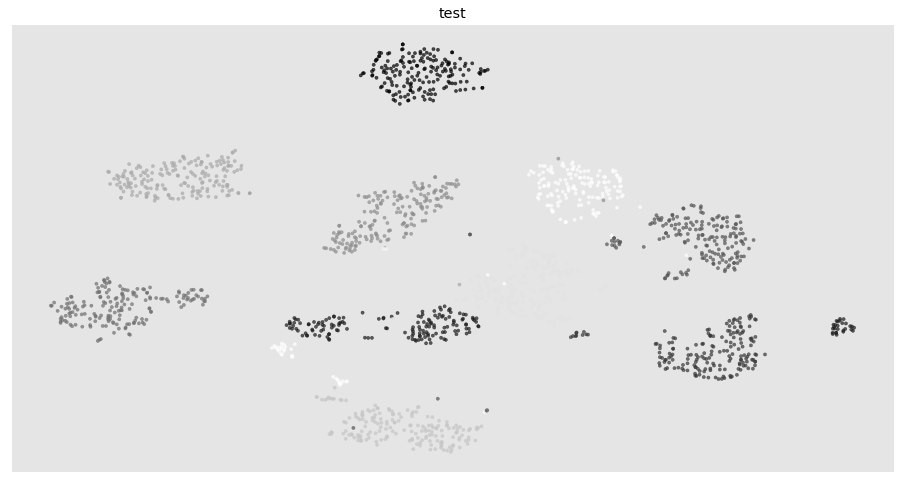

In [107]:
plot_tsne('test', ds_2d);

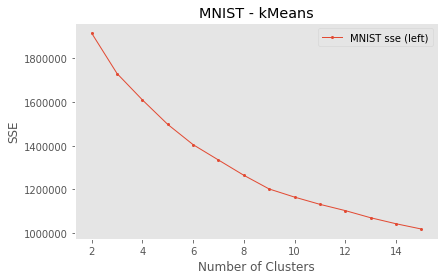

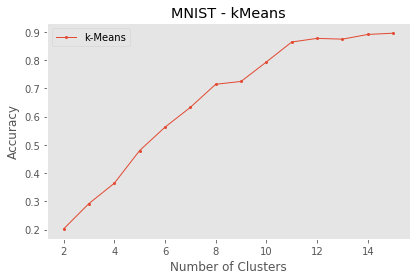

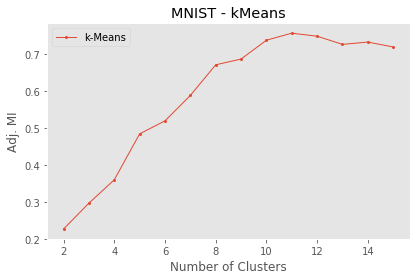

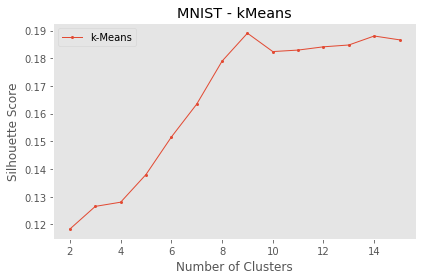

In [171]:
# k-means
plt.rc('figure', figsize=(6, 4))
plot_sse('MNIST - kMeans', sse).show();
plot_acc_kmeans('MNIST - kMeans', acc).show();
plot_adj_mi_kmeans('MNIST - kMeans', adj_mi).show();
plot_sil_score_kmeans('MNIST - kMeans', sil).show();

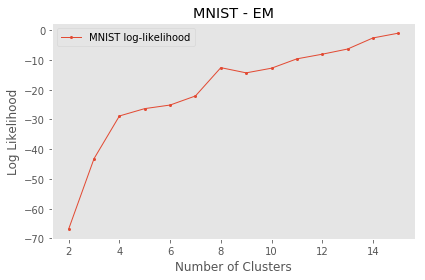

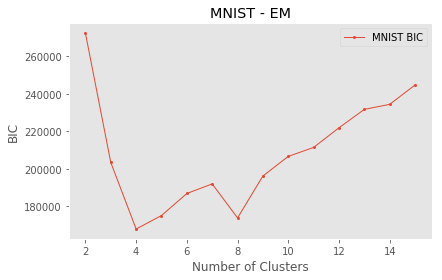

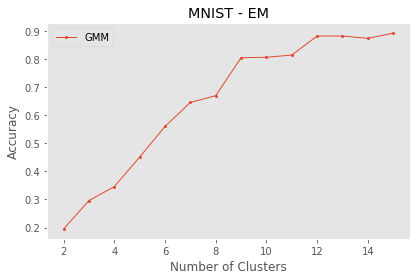

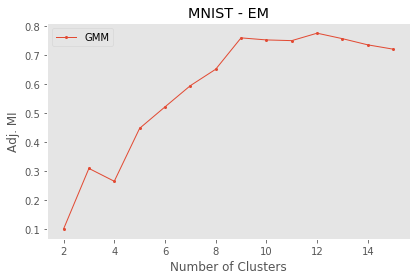

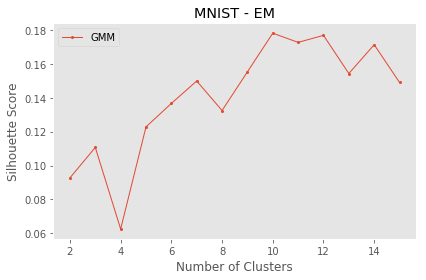

In [172]:
# EM
plt.rc('figure', figsize=(6, 4))
plot_loglikelihood('MNIST - EM', ll).show();
plot_bic('MNIST - EM', bic).show();
plot_acc_gmm('MNIST - EM', acc).show();
plot_adj_mi_gmm('MNIST - EM', adj_mi).show();
plot_sil_score_gmm('MNIST - EM', sil).show();

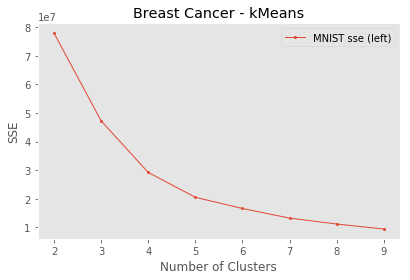

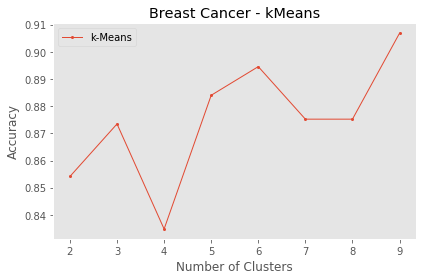

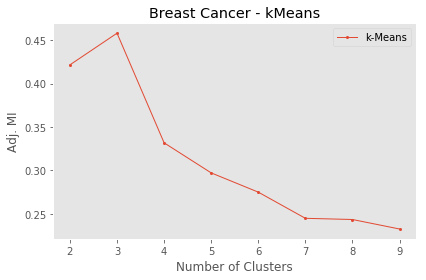

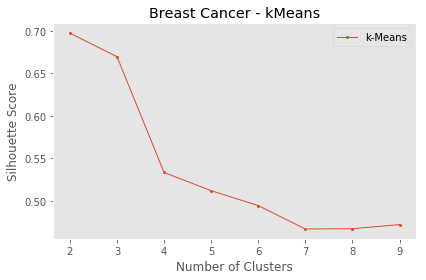

In [179]:
# k-means
plt.rc('figure', figsize=(6, 4))
plot_sse('Breast Cancer - kMeans', sse).show();
plot_acc_kmeans('Breast Cancer - kMeans', acc).show();
plot_adj_mi_kmeans('Breast Cancer - kMeans', adj_mi).show();
plot_sil_score_kmeans('Breast Cancer - kMeans', sil).show();

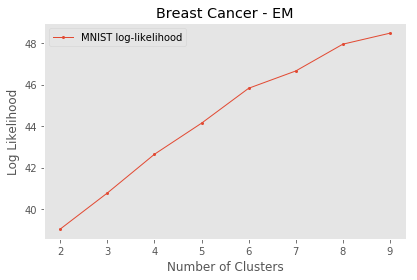

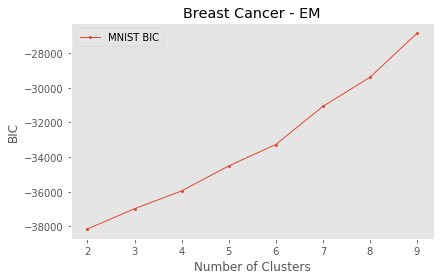

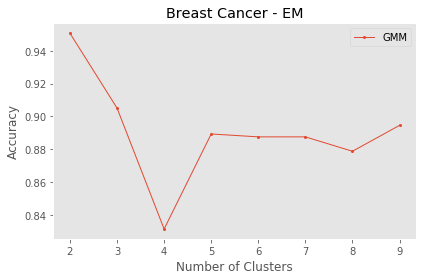

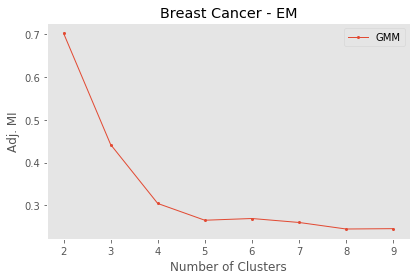

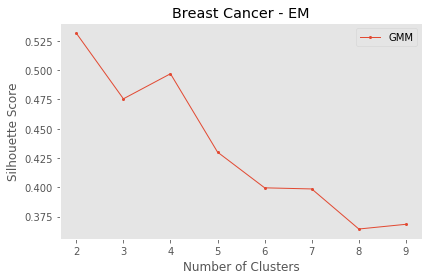

In [180]:
# EM
plt.rc('figure', figsize=(6, 4))
plot_loglikelihood('Breast Cancer - EM', ll).show();
plot_bic('Breast Cancer - EM', bic).show();
plot_acc_gmm('Breast Cancer - EM', acc).show();
plot_adj_mi_gmm('Breast Cancer - EM', adj_mi).show();
plot_sil_score_gmm('Breast Cancer - EM', sil).show();

## Dimensionality Reduction

In [285]:
from kneed import KneeLocator

def find_knee(values):
    # get coordinates of all the points
    nPoints = len(values)
    allCoord = np.vstack((range(nPoints), values)).T
    # np.array([range(nPoints), values])

    # get the first point
    firstPoint = allCoord[0]
    # get vector between first and last point - this is the line
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec ** 2))

    # find the distance from each point to the line:
    # vector between all points and first point
    vecFromFirst = allCoord - firstPoint

    # To calculate the distance to the line, we split vecFromFirst into two
    # components, one that is parallel to the line and one that is perpendicular
    # Then, we take the norm of the part that is perpendicular to the line and
    # get the distance.
    # We find the vector parallel to the line by projecting vecFromFirst onto
    # the line. The perpendicular vector is vecFromFirst - vecFromFirstParallel
    # We project vecFromFirst by taking the scalar product of the vector with
    # the unit vector that points in the direction of the line (this gives us
    # the length of the projection of vecFromFirst onto the line). If we
    # multiply the scalar product by the unit vector, we have vecFromFirstParallel
    scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    vecToLine = vecFromFirst - vecFromFirstParallel

    # distance to line is the norm of vecToLine
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))

    # knee/elbow is the point with max distance value
    idxOfBestPoint = np.argmax(distToLine)
    return idxOfBestPoint


def plot_scree(title, df, problem_name, multiple_runs=False, xlabel='Number of Clusters', ylabel=None):
    if ylabel is None:
        ylabel = 'Kurtosis'
        if problem_name == 'PCA' or problem_name == 'SVD':
            ylabel = 'Variance'
        elif problem_name == 'RP1':
            ylabel = 'Pairwise distance corrcoef'
        elif problem_name == 'RP2':
            ylabel = 'Reconstruction Error'
        elif problem_name == 'RF':
            ylabel = 'Feature Importances'
    title = title.format(ylabel)

    plt.close()
    plt.figure()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.tight_layout()

    ax = plt.gca()

    x_points = df.index.values
    y_points = df[0]
    if multiple_runs:
        y_points = np.mean(df.iloc[:, 1:-1], axis=1)
        y_std = np.std(df.iloc[:, 1:-1], axis=1)
        plt.plot(x_points, y_points, 'o-', linewidth=1, markersize=2,
                 label=ylabel)
        plt.fill_between(x_points, y_points - y_std,
                         y_points + y_std, alpha=0.2)
    else:
        plt.plot(x_points, y_points, 'o-', linewidth=1, markersize=2,
                 label=ylabel)

    min_value = np.min(y_points)
    min_point = y_points.idxmin()
    max_value = np.max(y_points)
    max_point = y_points.idxmax()
    knee_point = find_knee(y_points)
    kl = KneeLocator(x_points, y_points)

    ax.axvline(x=min_point, linestyle="--", label="Min: {}".format(int(min_point)))
    ax.axvline(x=max_point, linestyle="--", label="Max: {}".format(int(max_point)))
    if kl.knee_x is not None:
        ax.axvline(x=kl.knee_x, linestyle="--", label="Knee: {}".format(kl.knee_x))
    else:
        ax.axvline(x=knee_point, linestyle="--", label="Knee: {}".format(knee_point))

    ax.set_xticks(df.index.values, minor=False)

    plt.legend(loc="best")

    return plt

In [276]:
from sklearn.preprocessing import StandardScaler

### PCA

In [200]:
from sklearn.decomposition import PCA

In [229]:
training_x = digits.data
training_x = StandardScaler().fit_transform(training_x)
training_y = digits.target

In [215]:
training_x = breast_cancer.data
training_x = StandardScaler().fit_transform(training_x)
training_y = breast_cancer.target

In [230]:
pca = PCA(random_state=seed)
pca.fit(training_x)
dfScree = pd.DataFrame(data=pca.explained_variance_, index=range(1, min(pca.explained_variance_.shape[0], 500) + 1))

No local maxima found in the distance curve
The line is probably not polynomial, try plotting
the distance curve with plt.plot(knee.xd, knee.yd)
Also check that you aren't mistakenly setting the curve argument


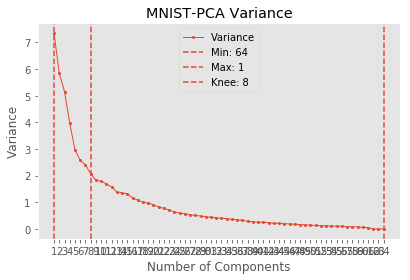

In [231]:
plot_scree('MNIST-PCA {}', dfScree, 'PCA', xlabel='Number of Components').show()

No local maxima found in the distance curve
The line is probably not polynomial, try plotting
the distance curve with plt.plot(knee.xd, knee.yd)
Also check that you aren't mistakenly setting the curve argument


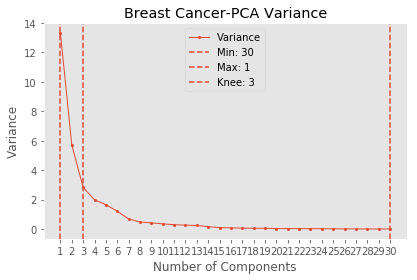

In [227]:
plot_scree('Breast Cancer-PCA {}', dfScree, 'PCA', xlabel='Number of Components').show()

### ICA

In [232]:
from sklearn.decomposition import FastICA

In [244]:
_dims = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]

In [233]:
training_x = digits.data
training_x = StandardScaler().fit_transform(training_x)
training_y = digits.target

In [256]:
training_x = breast_cancer.data
training_x = StandardScaler().fit_transform(training_x)
training_y = breast_cancer.target

In [257]:
ica = FastICA(random_state=seed)
kurt = {}
for dim in _dims:
    ica.set_params(n_components=dim)
    tmp = ica.fit_transform(training_x)
    tmp = pd.DataFrame(tmp)
    tmp = tmp.kurt(axis=0)
    kurt[dim] = tmp.abs().mean()
dfScree = pd.DataFrame(pd.Series(kurt))

/Users/frankz/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:305: UserWarning: n_components is too large: it will be set to 30
  warnings.warn('n_components is too large: it will be set to %s' % n_components)
/Users/frankz/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:305: UserWarning: n_components is too large: it will be set to 30
  warnings.warn('n_components is too large: it will be set to %s' % n_components)
/Users/frankz/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:305: UserWarning: n_components is too large: it will be set to 30
  warnings.warn('n_components is too large: it will be set to %s' % n_components)
/Users/frankz/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:305: UserWarning: n_components is too large: it will be set to 30
  warnings.warn('n_components is too large: it will be set to %s' % n_components)
/Users/frankz/anaconda3/lib/python3.7/site-packages/sklearn/deco

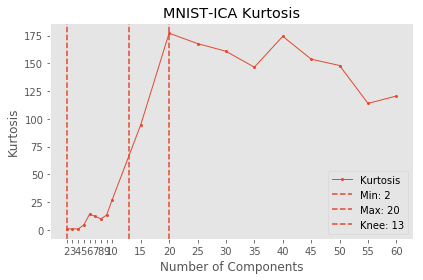

In [254]:
plot_scree('MNIST-ICA {}', dfScree, 'ICA', xlabel='Number of Components').show()

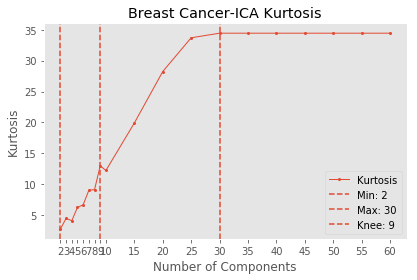

In [258]:
plot_scree('Breast Cancer-ICA {}', dfScree, 'ICA', xlabel='Number of Components').show()

### RP

In [277]:
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection
from sklearn.metrics.pairwise import pairwise_distances
from itertools import product
import scipy.sparse as sps

In [278]:
def pairwise_dist_corr(x1, x2):
    assert x1.shape[0] == x2.shape[0]

    d1 = pairwise_distances(x1)
    d2 = pairwise_distances(x2)
    return np.corrcoef(d1.ravel(), d2.ravel())[0, 1]

def reconstruction_error(projections, x):
    w = projections.components_
    if sps.issparse(w):
        w = w.todense()
    p = pinv(w)
    reconstructed = ((p@w)@(x.T)).T  # Unproject projected data
    errors = np.square(x-reconstructed)
    return np.nanmean(errors)

In [279]:
_dims = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]

In [280]:
training_x = digits.data
training_x = StandardScaler().fit_transform(training_x)
training_y = digits.target

In [281]:
tmp = defaultdict(dict)
for i, dim in product(range(10), _dims):
    rp = SparseRandomProjection(random_state=i, n_components=dim)
    rp.fit(training_x)
    tmp[dim][i] = reconstruction_error(rp, training_x)
dfScree2 = pd.DataFrame(tmp).T

No local maxima found in the distance curve
The line is probably not polynomial, try plotting
the distance curve with plt.plot(knee.xd, knee.yd)
Also check that you aren't mistakenly setting the curve argument


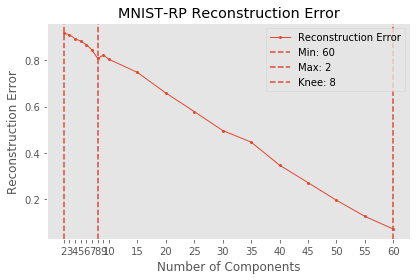

In [286]:
plot_scree('MNIST-RP {}', dfScree2, 'RP2', xlabel='Number of Components').show()

In [283]:
tmp = defaultdict(dict)
for i, dim in product(range(10), _dims):
    rp = SparseRandomProjection(random_state=i, n_components=dim)
    tmp[dim][i] = pairwise_dist_corr(rp.fit_transform(training_x), training_x)
dfScree1 = pd.DataFrame(tmp).T

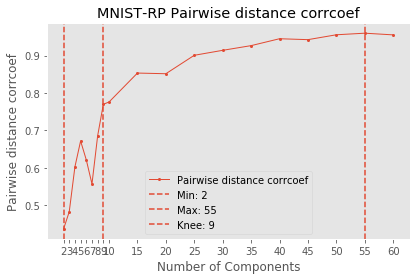

In [287]:
plot_scree('MNIST-RP {}', dfScree1, 'RP1', xlabel='Number of Components').show()

In [294]:
training_x = breast_cancer.data
training_x = StandardScaler().fit_transform(training_x)
training_y = breast_cancer.target

In [295]:
_dims = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30]

In [296]:
tmp = defaultdict(dict)
for i, dim in product(range(10), _dims):
    rp = SparseRandomProjection(random_state=i, n_components=dim)
    rp.fit(training_x)
    tmp[dim][i] = reconstruction_error(rp, training_x)
dfScree2 = pd.DataFrame(tmp).T

No local maxima found in the distance curve
The line is probably not polynomial, try plotting
the distance curve with plt.plot(knee.xd, knee.yd)
Also check that you aren't mistakenly setting the curve argument


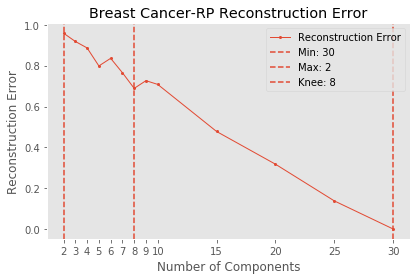

In [297]:
plot_scree('Breast Cancer-RP {}', dfScree2, 'RP2', xlabel='Number of Components').show()

In [298]:
tmp = defaultdict(dict)
for i, dim in product(range(10), _dims):
    rp = SparseRandomProjection(random_state=i, n_components=dim)
    tmp[dim][i] = pairwise_dist_corr(rp.fit_transform(training_x), training_x)
dfScree1 = pd.DataFrame(tmp).T

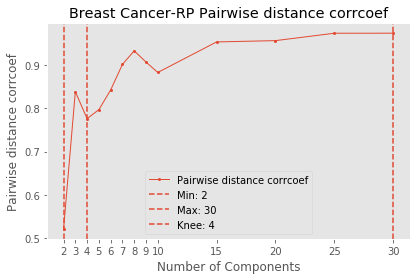

In [299]:
plot_scree('Breast Cancer-RP {}', dfScree1, 'RP1', xlabel='Number of Components').show()

### RF

In [307]:
from sklearn.ensemble import RandomForestClassifier

In [308]:
training_x = digits.data
training_x = StandardScaler().fit_transform(training_x)
training_y = digits.target

In [309]:
rfc = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=seed)
fs = rfc.fit(training_x, training_y).feature_importances_
dfScree = pd.DataFrame(pd.Series(np.sort(fs)[::-1]))

No local maxima found in the distance curve
The line is probably not polynomial, try plotting
the distance curve with plt.plot(knee.xd, knee.yd)
Also check that you aren't mistakenly setting the curve argument


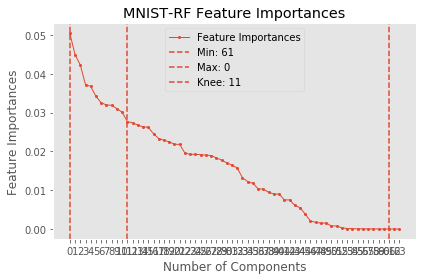

In [310]:
plot_scree('MNIST-RF {}', dfScree, 'RF', xlabel='Number of Components').show()

In [311]:
training_x = breast_cancer.data
training_x = StandardScaler().fit_transform(training_x)
training_y = breast_cancer.target

In [312]:
rfc = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=seed)
fs = rfc.fit(training_x, training_y).feature_importances_
dfScree = pd.DataFrame(pd.Series(np.sort(fs)[::-1]))

No local maxima found in the distance curve
The line is probably not polynomial, try plotting
the distance curve with plt.plot(knee.xd, knee.yd)
Also check that you aren't mistakenly setting the curve argument


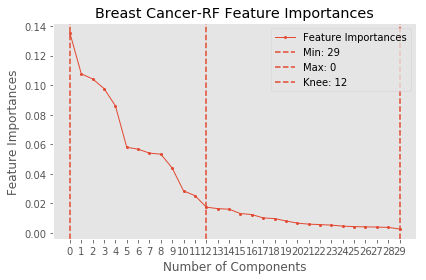

In [313]:
plot_scree('Breast Cancer-RF {}', dfScree, 'RF', xlabel='Number of Components').show()

## Clustering after DR

### PCA

In [314]:
from sklearn.decomposition import PCA

In [337]:
pca = PCA(n_components=8, random_state=seed)

In [336]:
training_x = digits.data
training_x = StandardScaler().fit_transform(training_x)
training_y = digits.target

In [340]:
training_x = pca.fit_transform(training_x)

In [342]:
training_x.shape

(1797, 8)

In [357]:
pca = PCA(n_components=3, random_state=seed)

In [358]:
training_x = breast_cancer.data
training_x = StandardScaler().fit_transform(training_x)
training_y = breast_cancer.target

In [359]:
training_x = pca.fit_transform(training_x)

In [360]:
training_x.shape

(569, 3)

In [361]:
sse = defaultdict(list)
ll = defaultdict(list)
bic = defaultdict(list)
sil = defaultdict(lambda: defaultdict(list))
sil_s = np.empty(shape=(2*len(_clusters)*training_x.shape[0],4), dtype='<U21')
acc = defaultdict(lambda: defaultdict(float))
adj_mi = defaultdict(lambda: defaultdict(float))
km = kmeans(random_state=seed)
gmm = GMM(random_state=seed)

j = 0
for k in range(2, 16):
    km.set_params(n_clusters=k)
    gmm.set_params(n_components=k)
    km.fit(training_x)
    gmm.fit(training_x)

    km_labels = km.predict(training_x)
    gmm_labels = gmm.predict(training_x)

    sil[k]['Kmeans'] = sil_score(training_x, km_labels)
    sil[k]['GMM'] = sil_score(training_x, gmm_labels)

    km_sil_samples = sil_samples(training_x, km_labels)
    gmm_sil_samples = sil_samples(training_x, gmm_labels)

    for i, x in enumerate(km_sil_samples):
        sil_s[j] = [k, 'Kmeans', round(x, 6), km_labels[i]]
        j += 1
    for i, x in enumerate(gmm_sil_samples):
        sil_s[j] = [k, 'GMM', round(x, 6), gmm_labels[i]]
        j += 1

    sse[k] = [km.score(training_x)]
    ll[k] = [gmm.score(training_x)]
    bic[k] = [gmm.bic(training_x)]

    acc[k]['Kmeans'] = cluster_acc(training_y, km_labels)
    acc[k]['GMM'] = cluster_acc(training_y, gmm_labels)

    adj_mi[k]['Kmeans'] = ami(training_y, km_labels)
    adj_mi[k]['GMM'] = ami(training_y, gmm_labels)

sse = (-pd.DataFrame(sse)).T
sse.index.name = 'k'
sse.columns = ['{} sse (left)'.format('MNIST')]

ll = pd.DataFrame(ll).T
ll.index.name = 'k'
ll.columns = ['{} log-likelihood'.format('MNIST')]

bic = pd.DataFrame(bic).T
bic.index.name = 'k'
bic.columns = ['{} BIC'.format('MNIST')]

sil = pd.DataFrame(sil).T
sil_s = pd.DataFrame(sil_s, columns=['k', 'type', 'score', 'label']).set_index('k')  #.T
acc = pd.DataFrame(acc).T
adj_mi = pd.DataFrame(adj_mi).T

sil.index.name = 'k'
sil_s.index.name = 'k'
acc.index.name = 'k'
adj_mi.index.name = 'k'

/Users/frankz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/frankz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/frankz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/frankz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior 

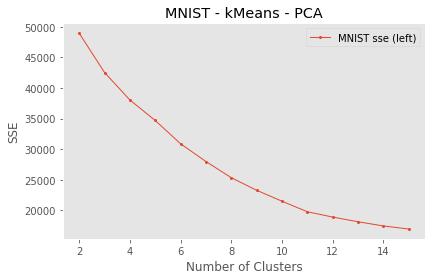

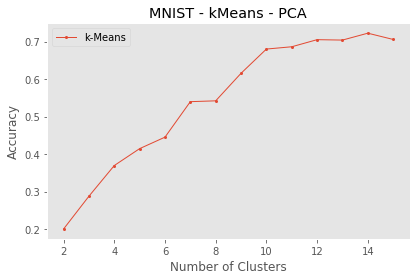

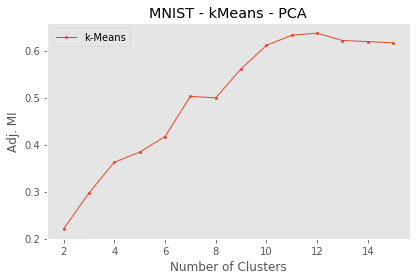

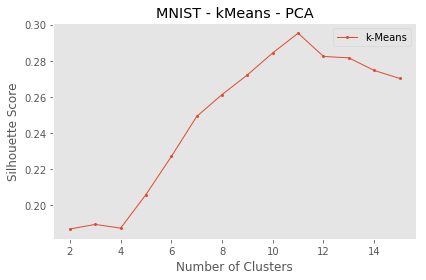

In [343]:
# k-means
plt.rc('figure', figsize=(6, 4))
plot_sse('MNIST - kMeans - PCA', sse).show();
plot_acc_kmeans('MNIST - kMeans - PCA', acc).show();
plot_adj_mi_kmeans('MNIST - kMeans - PCA', adj_mi).show();
plot_sil_score_kmeans('MNIST - kMeans - PCA', sil).show();

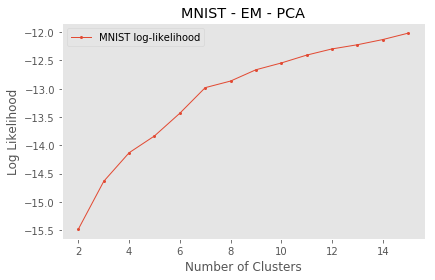

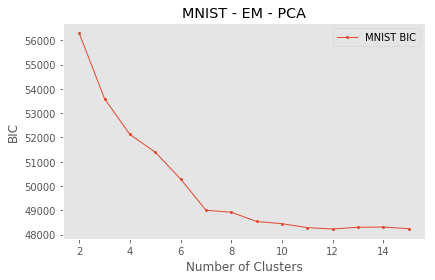

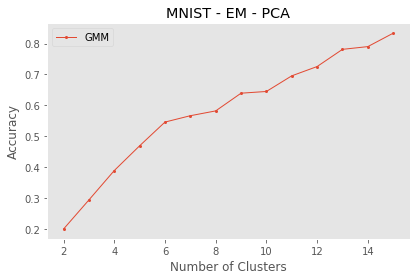

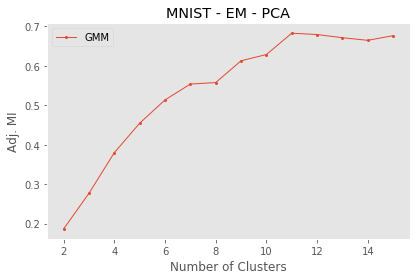

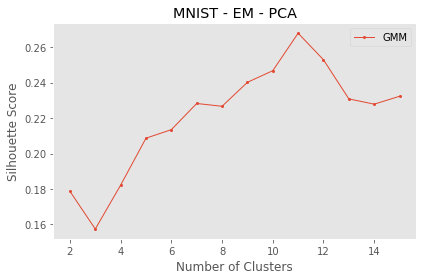

In [344]:
# EM
plt.rc('figure', figsize=(6, 4))
plot_loglikelihood('MNIST - EM - PCA', ll).show();
plot_bic('MNIST - EM - PCA', bic).show();
plot_acc_gmm('MNIST - EM - PCA', acc).show();
plot_adj_mi_gmm('MNIST - EM - PCA', adj_mi).show();
plot_sil_score_gmm('MNIST - EM - PCA', sil).show();

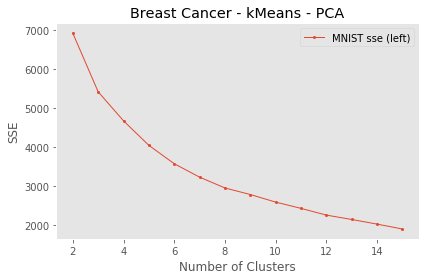

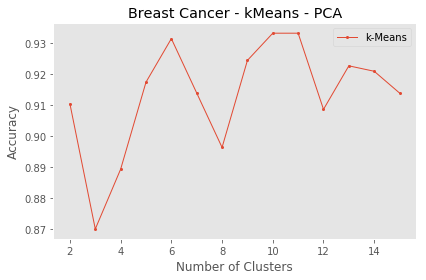

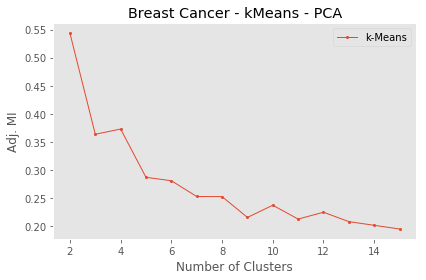

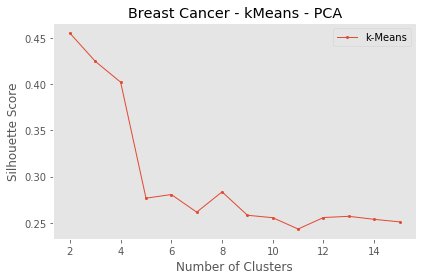

In [362]:
# k-means
plt.rc('figure', figsize=(6, 4))
plot_sse('Breast Cancer - kMeans - PCA', sse).show();
plot_acc_kmeans('Breast Cancer - kMeans - PCA', acc).show();
plot_adj_mi_kmeans('Breast Cancer - kMeans - PCA', adj_mi).show();
plot_sil_score_kmeans('Breast Cancer - kMeans - PCA', sil).show();

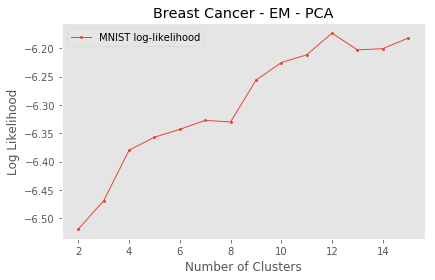

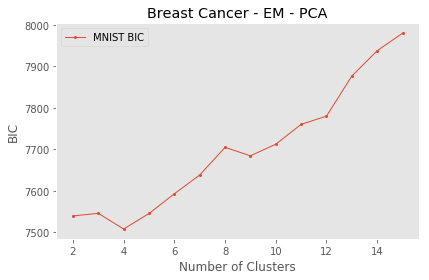

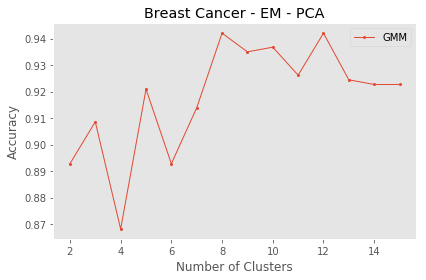

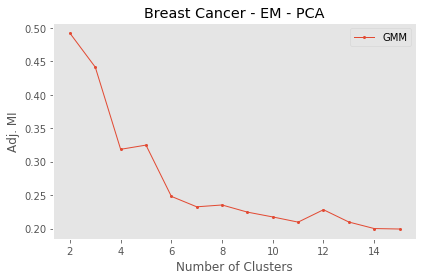

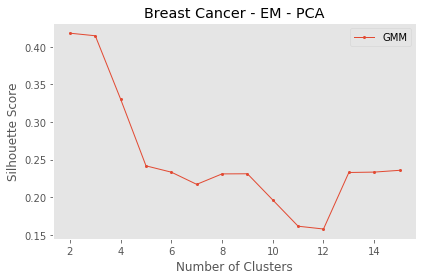

In [364]:
# EM
plt.rc('figure', figsize=(6, 4))
plot_loglikelihood('Breast Cancer - EM - PCA', ll).show();
plot_bic('Breast Cancer - EM - PCA', bic).show();
plot_acc_gmm('Breast Cancer - EM - PCA', acc).show();
plot_adj_mi_gmm('Breast Cancer - EM - PCA', adj_mi).show();
plot_sil_score_gmm('Breast Cancer - EM - PCA', sil).show();

### ICA

In [370]:
ica = FastICA(n_components=13, random_state=seed)

In [371]:
training_x = digits.data
training_x = StandardScaler().fit_transform(training_x)
training_y = digits.target

In [372]:
training_x = ica.fit_transform(training_x)

/Users/frankz/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


In [373]:
training_x.shape

(1797, 13)

In [379]:
ica = FastICA(n_components=9, random_state=seed)

In [380]:
training_x = breast_cancer.data
training_x = StandardScaler().fit_transform(training_x)
training_y = breast_cancer.target

In [381]:
training_x = ica.fit_transform(training_x)

In [382]:
training_x.shape

(569, 9)

In [383]:
sse = defaultdict(list)
ll = defaultdict(list)
bic = defaultdict(list)
sil = defaultdict(lambda: defaultdict(list))
sil_s = np.empty(shape=(2*len(_clusters)*training_x.shape[0],4), dtype='<U21')
acc = defaultdict(lambda: defaultdict(float))
adj_mi = defaultdict(lambda: defaultdict(float))
km = kmeans(random_state=seed)
gmm = GMM(random_state=seed)

j = 0
for k in range(2, 16):
    km.set_params(n_clusters=k)
    gmm.set_params(n_components=k)
    km.fit(training_x)
    gmm.fit(training_x)

    km_labels = km.predict(training_x)
    gmm_labels = gmm.predict(training_x)

    sil[k]['Kmeans'] = sil_score(training_x, km_labels)
    sil[k]['GMM'] = sil_score(training_x, gmm_labels)

    km_sil_samples = sil_samples(training_x, km_labels)
    gmm_sil_samples = sil_samples(training_x, gmm_labels)

    for i, x in enumerate(km_sil_samples):
        sil_s[j] = [k, 'Kmeans', round(x, 6), km_labels[i]]
        j += 1
    for i, x in enumerate(gmm_sil_samples):
        sil_s[j] = [k, 'GMM', round(x, 6), gmm_labels[i]]
        j += 1

    sse[k] = [km.score(training_x)]
    ll[k] = [gmm.score(training_x)]
    bic[k] = [gmm.bic(training_x)]

    acc[k]['Kmeans'] = cluster_acc(training_y, km_labels)
    acc[k]['GMM'] = cluster_acc(training_y, gmm_labels)

    adj_mi[k]['Kmeans'] = ami(training_y, km_labels)
    adj_mi[k]['GMM'] = ami(training_y, gmm_labels)

sse = (-pd.DataFrame(sse)).T
sse.index.name = 'k'
sse.columns = ['{} sse (left)'.format('MNIST')]

ll = pd.DataFrame(ll).T
ll.index.name = 'k'
ll.columns = ['{} log-likelihood'.format('MNIST')]

bic = pd.DataFrame(bic).T
bic.index.name = 'k'
bic.columns = ['{} BIC'.format('MNIST')]

sil = pd.DataFrame(sil).T
sil_s = pd.DataFrame(sil_s, columns=['k', 'type', 'score', 'label']).set_index('k')  #.T
acc = pd.DataFrame(acc).T
adj_mi = pd.DataFrame(adj_mi).T

sil.index.name = 'k'
sil_s.index.name = 'k'
acc.index.name = 'k'
adj_mi.index.name = 'k'

/Users/frankz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/frankz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/frankz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/frankz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior 

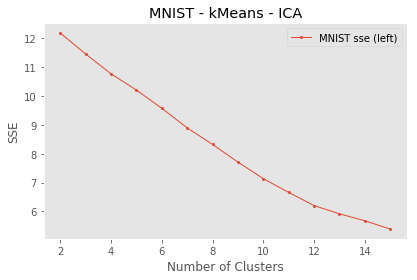

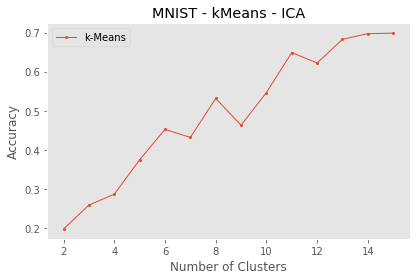

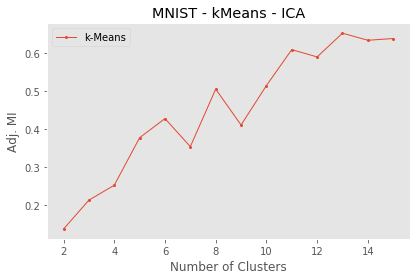

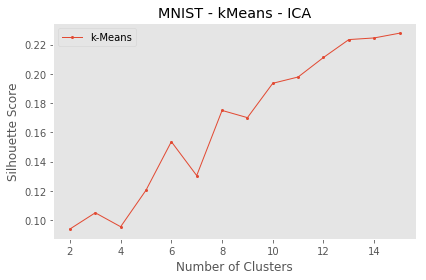

In [377]:
# k-means
plt.rc('figure', figsize=(6, 4))
plot_sse('MNIST - kMeans - ICA', sse).show();
plot_acc_kmeans('MNIST - kMeans - ICA', acc).show();
plot_adj_mi_kmeans('MNIST - kMeans - ICA', adj_mi).show();
plot_sil_score_kmeans('MNIST - kMeans - ICA', sil).show();

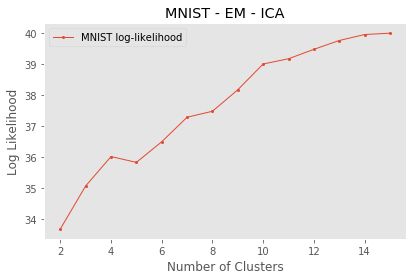

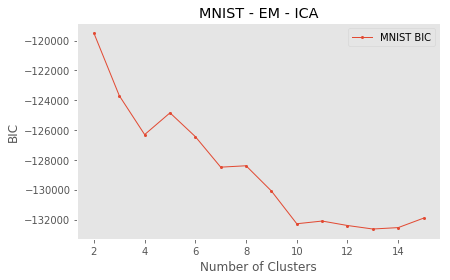

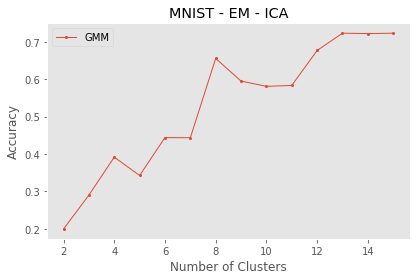

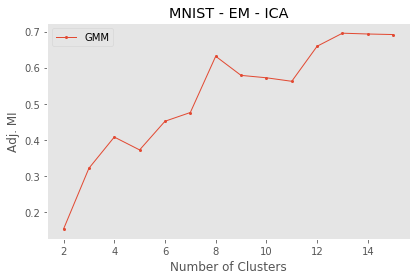

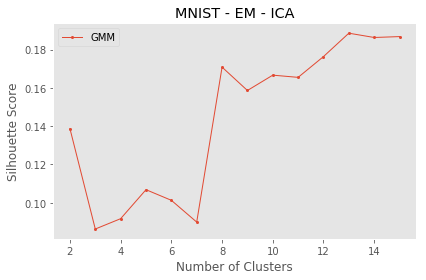

In [378]:
# EM
plt.rc('figure', figsize=(6, 4))
plot_loglikelihood('MNIST - EM - ICA', ll).show();
plot_bic('MNIST - EM - ICA', bic).show();
plot_acc_gmm('MNIST - EM - ICA', acc).show();
plot_adj_mi_gmm('MNIST - EM - ICA', adj_mi).show();
plot_sil_score_gmm('MNIST - EM - ICA', sil).show();

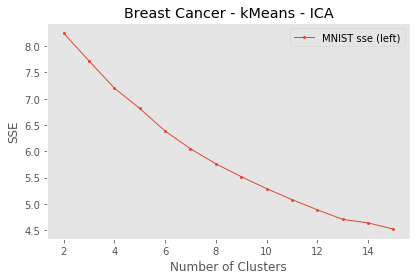

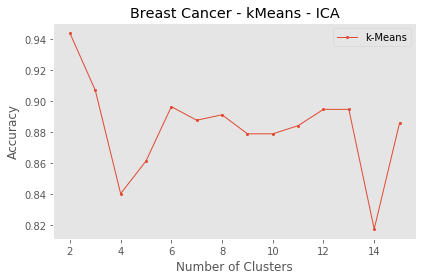

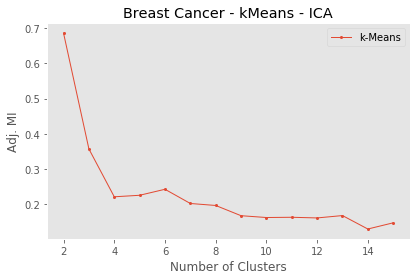

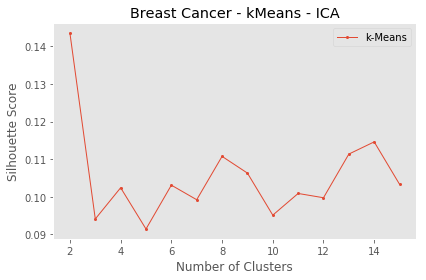

In [384]:
# k-means
plt.rc('figure', figsize=(6, 4))
plot_sse('Breast Cancer - kMeans - ICA', sse).show();
plot_acc_kmeans('Breast Cancer - kMeans - ICA', acc).show();
plot_adj_mi_kmeans('Breast Cancer - kMeans - ICA', adj_mi).show();
plot_sil_score_kmeans('Breast Cancer - kMeans - ICA', sil).show();

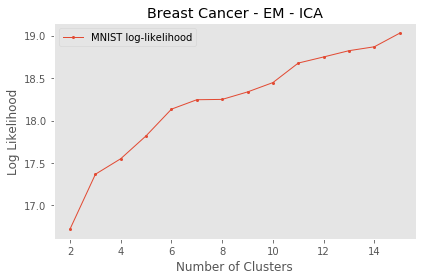

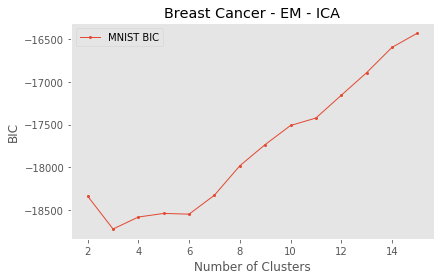

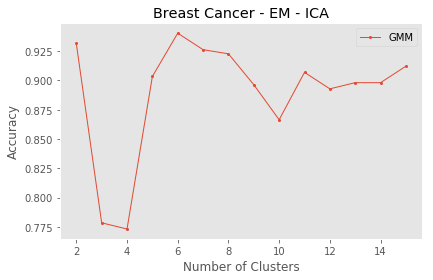

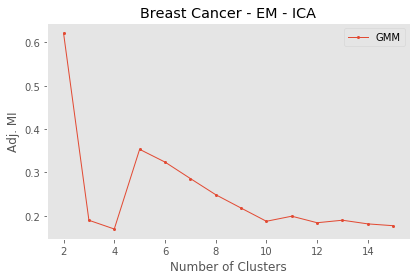

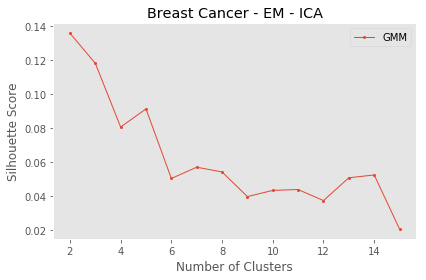

In [385]:
# EM
plt.rc('figure', figsize=(6, 4))
plot_loglikelihood('Breast Cancer - EM - ICA', ll).show();
plot_bic('Breast Cancer - EM - ICA', bic).show();
plot_acc_gmm('Breast Cancer - EM - ICA', acc).show();
plot_adj_mi_gmm('Breast Cancer - EM - ICA', adj_mi).show();
plot_sil_score_gmm('Breast Cancer - EM - ICA', sil).show();

### RP

In [404]:
rp = SparseRandomProjection(n_components=9, random_state=seed)

In [405]:
training_x = digits.data
training_x = StandardScaler().fit_transform(training_x)
training_y = digits.target

In [406]:
training_x = rp.fit_transform(training_x)

In [407]:
training_x.shape

(1797, 9)

In [411]:
rp = SparseRandomProjection(n_components=6, random_state=seed)

In [412]:
training_x = breast_cancer.data
training_x = StandardScaler().fit_transform(training_x)
training_y = breast_cancer.target

In [413]:
training_x = rp.fit_transform(training_x)

In [414]:
training_x.shape

(569, 6)

In [415]:
sse = defaultdict(list)
ll = defaultdict(list)
bic = defaultdict(list)
sil = defaultdict(lambda: defaultdict(list))
sil_s = np.empty(shape=(2*len(_clusters)*training_x.shape[0],4), dtype='<U21')
acc = defaultdict(lambda: defaultdict(float))
adj_mi = defaultdict(lambda: defaultdict(float))
km = kmeans(random_state=seed)
gmm = GMM(random_state=seed)

j = 0
for k in range(2, 16):
    km.set_params(n_clusters=k)
    gmm.set_params(n_components=k)
    km.fit(training_x)
    gmm.fit(training_x)

    km_labels = km.predict(training_x)
    gmm_labels = gmm.predict(training_x)

    sil[k]['Kmeans'] = sil_score(training_x, km_labels)
    sil[k]['GMM'] = sil_score(training_x, gmm_labels)

    km_sil_samples = sil_samples(training_x, km_labels)
    gmm_sil_samples = sil_samples(training_x, gmm_labels)

    for i, x in enumerate(km_sil_samples):
        sil_s[j] = [k, 'Kmeans', round(x, 6), km_labels[i]]
        j += 1
    for i, x in enumerate(gmm_sil_samples):
        sil_s[j] = [k, 'GMM', round(x, 6), gmm_labels[i]]
        j += 1

    sse[k] = [km.score(training_x)]
    ll[k] = [gmm.score(training_x)]
    bic[k] = [gmm.bic(training_x)]

    acc[k]['Kmeans'] = cluster_acc(training_y, km_labels)
    acc[k]['GMM'] = cluster_acc(training_y, gmm_labels)

    adj_mi[k]['Kmeans'] = ami(training_y, km_labels)
    adj_mi[k]['GMM'] = ami(training_y, gmm_labels)

sse = (-pd.DataFrame(sse)).T
sse.index.name = 'k'
sse.columns = ['{} sse (left)'.format('MNIST')]

ll = pd.DataFrame(ll).T
ll.index.name = 'k'
ll.columns = ['{} log-likelihood'.format('MNIST')]

bic = pd.DataFrame(bic).T
bic.index.name = 'k'
bic.columns = ['{} BIC'.format('MNIST')]

sil = pd.DataFrame(sil).T
sil_s = pd.DataFrame(sil_s, columns=['k', 'type', 'score', 'label']).set_index('k')  #.T
acc = pd.DataFrame(acc).T
adj_mi = pd.DataFrame(adj_mi).T

sil.index.name = 'k'
sil_s.index.name = 'k'
acc.index.name = 'k'
adj_mi.index.name = 'k'

/Users/frankz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/frankz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/frankz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/frankz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior 

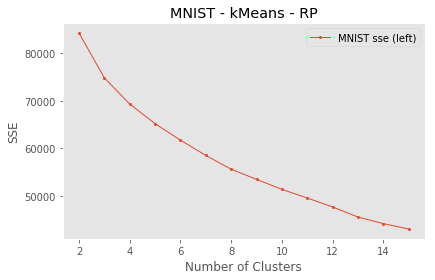

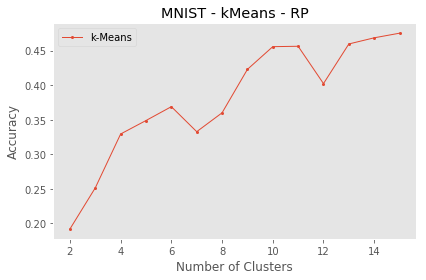

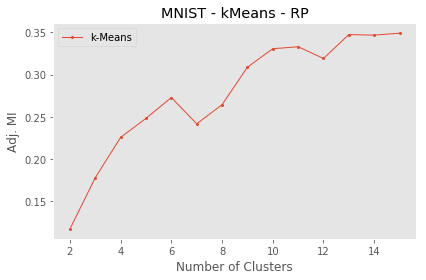

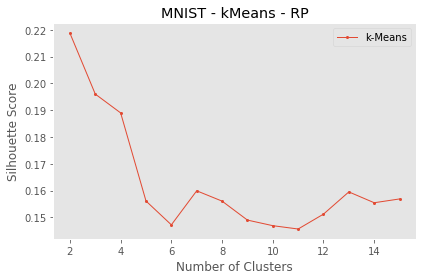

In [409]:
# k-means
plt.rc('figure', figsize=(6, 4))
plot_sse('MNIST - kMeans - RP', sse).show();
plot_acc_kmeans('MNIST - kMeans - RP', acc).show();
plot_adj_mi_kmeans('MNIST - kMeans - RP', adj_mi).show();
plot_sil_score_kmeans('MNIST - kMeans - RP', sil).show();

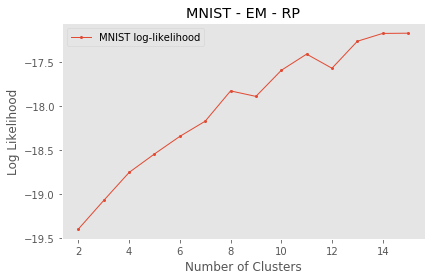

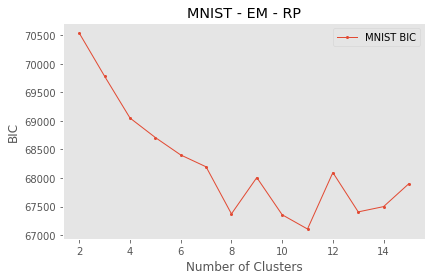

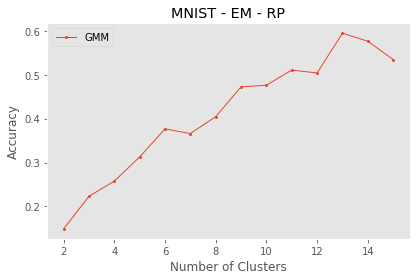

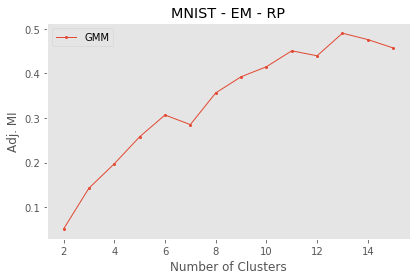

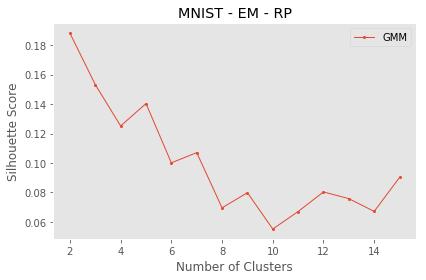

In [410]:
# EM
plt.rc('figure', figsize=(6, 4))
plot_loglikelihood('MNIST - EM - RP', ll).show();
plot_bic('MNIST - EM - RP', bic).show();
plot_acc_gmm('MNIST - EM - RP', acc).show();
plot_adj_mi_gmm('MNIST - EM - RP', adj_mi).show();
plot_sil_score_gmm('MNIST - EM - RP', sil).show();

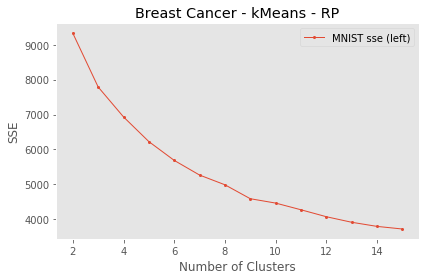

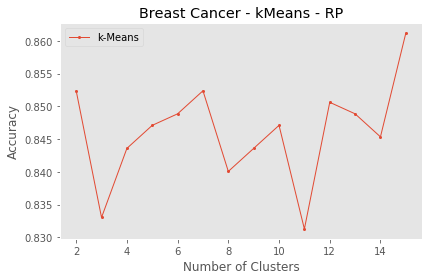

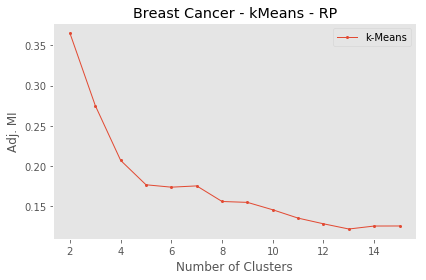

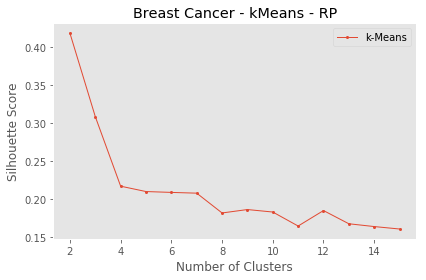

In [416]:
# k-means
plt.rc('figure', figsize=(6, 4))
plot_sse('Breast Cancer - kMeans - RP', sse).show();
plot_acc_kmeans('Breast Cancer - kMeans - RP', acc).show();
plot_adj_mi_kmeans('Breast Cancer - kMeans - RP', adj_mi).show();
plot_sil_score_kmeans('Breast Cancer - kMeans - RP', sil).show();

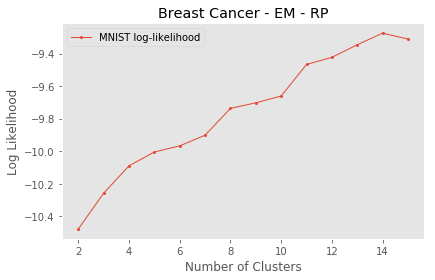

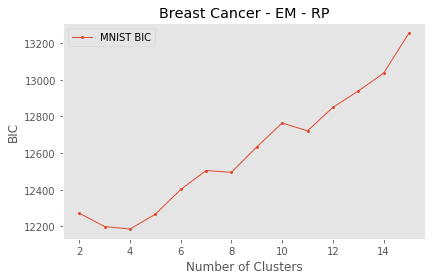

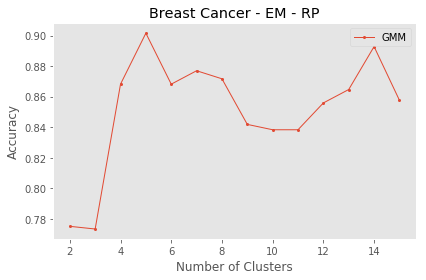

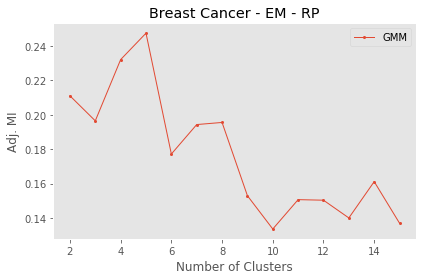

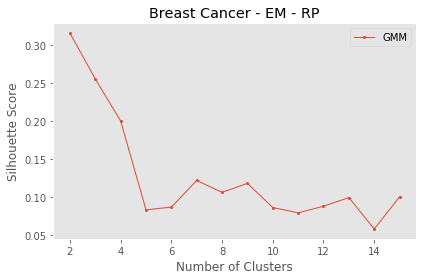

In [417]:
# EM
plt.rc('figure', figsize=(6, 4))
plot_loglikelihood('Breast Cancer - EM - RP', ll).show();
plot_bic('Breast Cancer - EM - RP', bic).show();
plot_acc_gmm('Breast Cancer - EM - RP', acc).show();
plot_adj_mi_gmm('Breast Cancer - EM - RP', adj_mi).show();
plot_sil_score_gmm('Breast Cancer - EM - RP', sil).show();

### RF

In [419]:
from sklearn.base import TransformerMixin,BaseEstimator

In [420]:
class ImportanceSelect(BaseEstimator, TransformerMixin):
    def __init__(self, model, n=1):
        self.model = model
        self.n = n

    def fit(self, *args, **kwargs):
        self.model.fit(*args, **kwargs)
        return self

    def transform(self, X):
        return X[:, self.model.feature_importances_.argsort()[::-1][:self.n]]

In [421]:
training_x = digits.data
training_x = StandardScaler().fit_transform(training_x)
training_y = digits.target

In [422]:
rfc = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=seed)
rfc.fit(training_x, training_y)
filtr = ImportanceSelect(rfc, 11)

In [425]:
training_x = filtr.fit_transform(training_x, training_y)

In [426]:
training_x.shape

(1797, 11)

In [430]:
training_x = breast_cancer.data
training_x = StandardScaler().fit_transform(training_x)
training_y = breast_cancer.target

In [431]:
rfc = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=seed)
rfc.fit(training_x, training_y)
filtr = ImportanceSelect(rfc, 12)

In [432]:
training_x = filtr.fit_transform(training_x, training_y)

In [433]:
training_x.shape

(569, 12)

In [434]:
sse = defaultdict(list)
ll = defaultdict(list)
bic = defaultdict(list)
sil = defaultdict(lambda: defaultdict(list))
sil_s = np.empty(shape=(2*len(_clusters)*training_x.shape[0],4), dtype='<U21')
acc = defaultdict(lambda: defaultdict(float))
adj_mi = defaultdict(lambda: defaultdict(float))
km = kmeans(random_state=seed)
gmm = GMM(random_state=seed)

j = 0
for k in range(2, 16):
    km.set_params(n_clusters=k)
    gmm.set_params(n_components=k)
    km.fit(training_x)
    gmm.fit(training_x)

    km_labels = km.predict(training_x)
    gmm_labels = gmm.predict(training_x)

    sil[k]['Kmeans'] = sil_score(training_x, km_labels)
    sil[k]['GMM'] = sil_score(training_x, gmm_labels)

    km_sil_samples = sil_samples(training_x, km_labels)
    gmm_sil_samples = sil_samples(training_x, gmm_labels)

    for i, x in enumerate(km_sil_samples):
        sil_s[j] = [k, 'Kmeans', round(x, 6), km_labels[i]]
        j += 1
    for i, x in enumerate(gmm_sil_samples):
        sil_s[j] = [k, 'GMM', round(x, 6), gmm_labels[i]]
        j += 1

    sse[k] = [km.score(training_x)]
    ll[k] = [gmm.score(training_x)]
    bic[k] = [gmm.bic(training_x)]

    acc[k]['Kmeans'] = cluster_acc(training_y, km_labels)
    acc[k]['GMM'] = cluster_acc(training_y, gmm_labels)

    adj_mi[k]['Kmeans'] = ami(training_y, km_labels)
    adj_mi[k]['GMM'] = ami(training_y, gmm_labels)

sse = (-pd.DataFrame(sse)).T
sse.index.name = 'k'
sse.columns = ['{} sse (left)'.format('MNIST')]

ll = pd.DataFrame(ll).T
ll.index.name = 'k'
ll.columns = ['{} log-likelihood'.format('MNIST')]

bic = pd.DataFrame(bic).T
bic.index.name = 'k'
bic.columns = ['{} BIC'.format('MNIST')]

sil = pd.DataFrame(sil).T
sil_s = pd.DataFrame(sil_s, columns=['k', 'type', 'score', 'label']).set_index('k')  #.T
acc = pd.DataFrame(acc).T
adj_mi = pd.DataFrame(adj_mi).T

sil.index.name = 'k'
sil_s.index.name = 'k'
acc.index.name = 'k'
adj_mi.index.name = 'k'

/Users/frankz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/frankz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/frankz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/frankz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior 

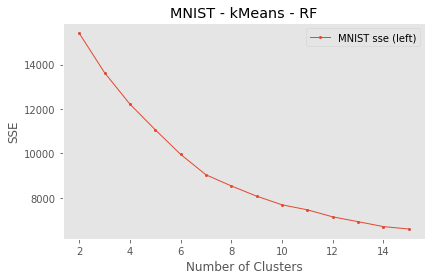

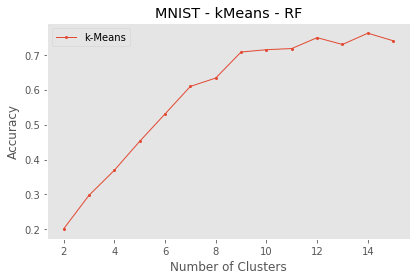

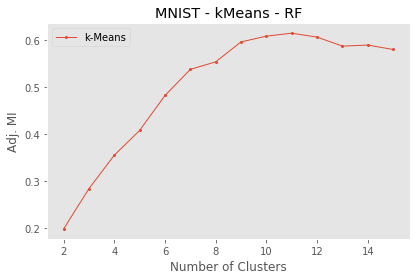

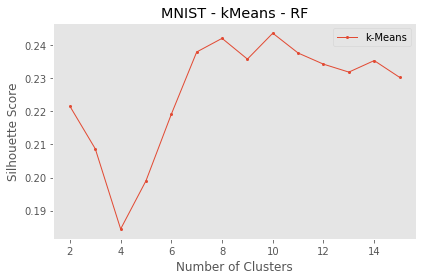

In [428]:
# k-means
plt.rc('figure', figsize=(6, 4))
plot_sse('MNIST - kMeans - RF', sse).show();
plot_acc_kmeans('MNIST - kMeans - RF', acc).show();
plot_adj_mi_kmeans('MNIST - kMeans - RF', adj_mi).show();
plot_sil_score_kmeans('MNIST - kMeans - RF', sil).show();

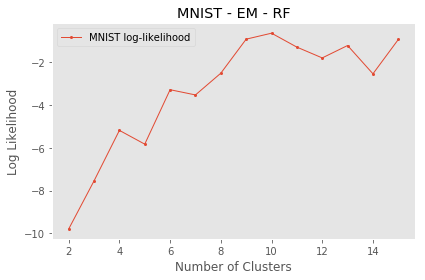

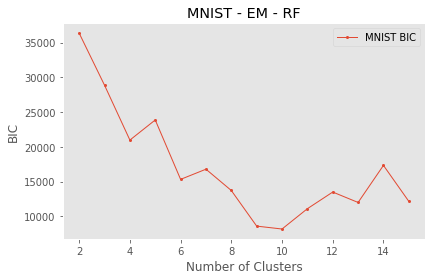

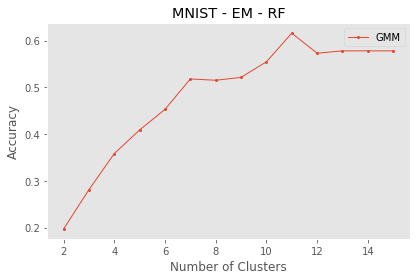

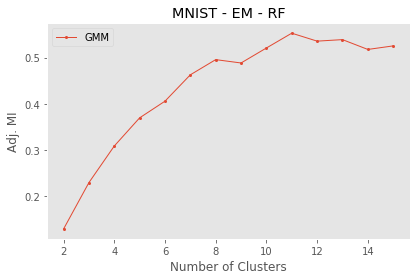

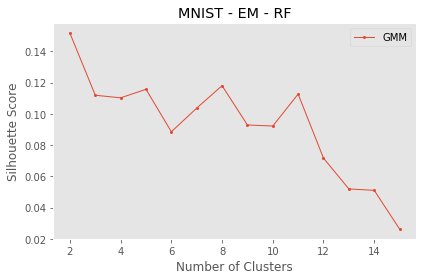

In [429]:
# EM
plt.rc('figure', figsize=(6, 4))
plot_loglikelihood('MNIST - EM - RF', ll).show();
plot_bic('MNIST - EM - RF', bic).show();
plot_acc_gmm('MNIST - EM - RF', acc).show();
plot_adj_mi_gmm('MNIST - EM - RF', adj_mi).show();
plot_sil_score_gmm('MNIST - EM - RF', sil).show();

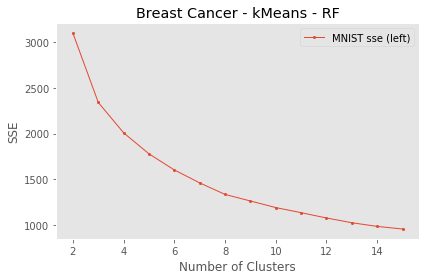

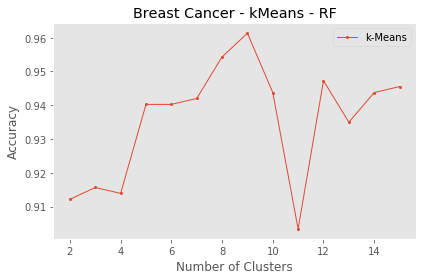

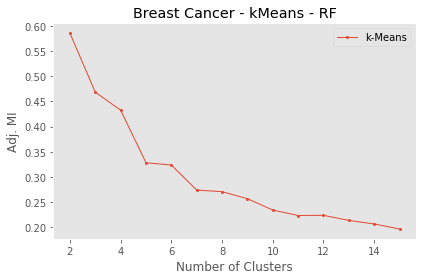

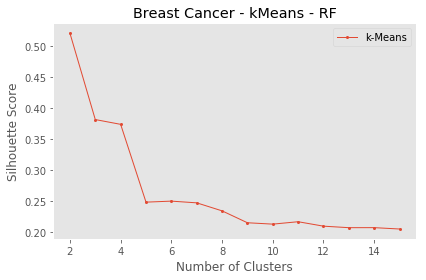

In [435]:
# k-means
plt.rc('figure', figsize=(6, 4))
plot_sse('Breast Cancer - kMeans - RF', sse).show();
plot_acc_kmeans('Breast Cancer - kMeans - RF', acc).show();
plot_adj_mi_kmeans('Breast Cancer - kMeans - RF', adj_mi).show();
plot_sil_score_kmeans('Breast Cancer - kMeans - RF', sil).show();

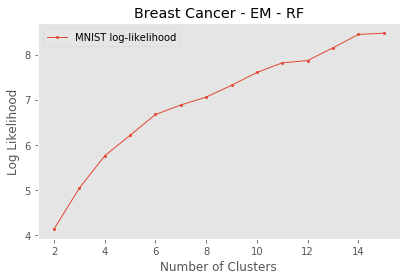

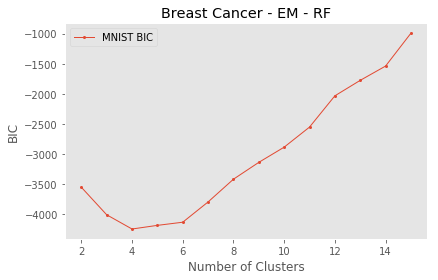

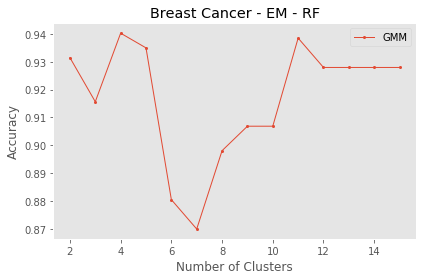

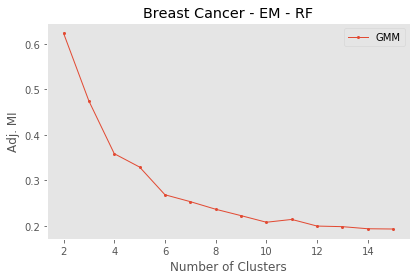

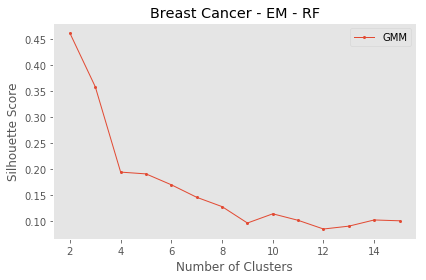

In [436]:
# EM
plt.rc('figure', figsize=(6, 4))
plot_loglikelihood('Breast Cancer - EM - RF', ll).show();
plot_bic('Breast Cancer - EM - RF', bic).show();
plot_acc_gmm('Breast Cancer - EM - RF', acc).show();
plot_adj_mi_gmm('Breast Cancer - EM - RF', adj_mi).show();
plot_sil_score_gmm('Breast Cancer - EM - RF', sil).show();